In [2]:
import torch

## preprocess data by 

In [3]:
#connect Gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#get data
import pandas as pd
import sklearn as sk

In [5]:
train_dataset = pd.read_csv('drive/MyDrive/Colab Notebooks/train.csv',header=None)
test_dataset = pd.read_csv('drive/MyDrive/Colab Notebooks/test.csv',header=None)

In [6]:
#print sample
for col in train_dataset.columns:
    print(col)
for col in test_dataset.columns:
    print(col)

0
1
0
1


In [7]:
#change column name
train_dataset=train_dataset.rename(columns={0: "polarity", 1: "reviews"}) 
test_dataset=test_dataset.rename(columns={0: "polarity", 1: "reviews"})

In [8]:
train_dataset.head()

,polarity,reviews
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [9]:
test_dataset.head()

,polarity,reviews
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...


In [10]:
print(len(train_dataset))
print(len(test_dataset))

560000
38000


In [11]:
#check if there is empty data
train_validated=train_dataset[train_dataset['polarity'].notnull()]
train_validated=train_validated[train_validated['reviews'].notnull()]
train_validated=train_validated[(train_validated['polarity']>=1) & (train_validated['polarity']<=2)]
len(train_validated)

560000

In [12]:
# check validity of polarity 
test_validaded=test_dataset[test_dataset['polarity'].notnull()]
test_validaded=test_validaded[test_validaded['reviews'].notnull()]
test_validaded=test_validaded[(test_validaded['polarity']>=1) & (test_validaded['polarity']<=2)]
len(test_validaded)

38000

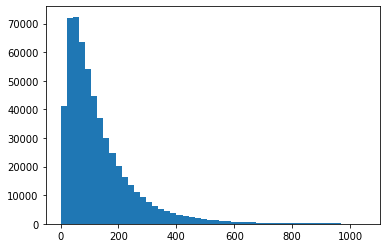

In [13]:
#plot the length of text
import matplotlib.pyplot as plt
review_lengths = []
for review_text in train_validated['reviews']:
    review_text=review_text.split()
    review_lengths.append(len(review_text))

plt.hist(review_lengths, bins=50)
plt.show()

In [14]:
#print text only for words less than 5
for review_text in train_validated['reviews'][:5000]:
    review_text=review_text.split()
    if len(review_text)<=5:
        print(review_text)

['Hoofah.']
['Nope!']
["It's", 'not', 'that', 'delish.']
['Great', 'customer', 'service!!!']
['ewwww']
['Great']
['Not', 'Tasty', 'At', 'All.']
['Good', 'food']
['A']
['Fabulous!']
['Awesome.', 'Nuff', 'sed']
['Out', 'of', 'business.']
['Great', 'food', 'and', 'great', 'pricing.']
["It's", 'an', 'IGA', 'now.']
['best', 'pizza', 'on', 'beverly', 'rd']
['Beer', 'cave!!']
['Consumer', 'alert...', 'rats!']
['Fantastic', 'martinis!!']
['Since', 'closed.', 'Surprise', 'surprise.']
['Awesome']
['Super', 'Sundae.']
['completely', 'worthless', 'wifi.']
['Awesome', 'chowder', 'but', "that's", 'it...']
['Flies', 'in', 'this', 'place.']
['They', 'only', 'deliver', 'through', 'WheelDeliver.com']
['Love', 'the', 'dragon', 'roll.']
['Exquisite!!']
['good', 'food.\\ngood', 'drinks.\\ngood', 'patio.\\nGREAT', 'urinal.']
['Avg', 'food,', 'too', 'salty.']
['Oh.', 'My.', 'God.', 'So.', 'Good.']
['Nice', 'place.', 'I', 'like', 'it.']
['www.bigtsreviews.com']
['.']
['Too', 'pricey', 'for', 'the', 'quality.'

In [15]:
# filter out anything bigger 300, for the efficiency
MAX_REVIEW_LENGTH = 300

def filter_output_by_length(review_text):
#     print(review_text[:5])
    return len(review_text.split()) <= MAX_REVIEW_LENGTH

In [16]:
#check the data after filter
import numpy as np

polarity_filtered, reviews_filtered = zip(*((pol, rev) for pol, rev in zip(train_validated['polarity'], train_validated['reviews']) if filter_output_by_length(rev)))
train_filtered = {'polarity': polarity_filtered,
        'reviews': reviews_filtered
        }

train_filtered = pd.DataFrame(train_filtered, columns = ['polarity', 'reviews'])
print('Dataset size BEFORE filtering: ', len(train_validated))
print('Dataset size AFTER filtering: ', len(train_filtered))
print('Number of eliminated recipes: ', len(train_validated) - len(train_filtered))

Dataset size BEFORE filtering:  560000
Dataset size AFTER filtering:  511846
Number of eliminated recipes:  48154


In [17]:
#datafram to list
train_records = train_filtered.to_records(index=False)
train_records = list(train_records)

In [18]:
test_records = test_validaded.to_records(index=False)
test_records = list(test_records)

In [19]:
for _,text in test_records[:3]:
  print(text)

Contrary to other reviews, I have zero complaints about the service or the prices. I have been getting tire service here for the past 5 years now, and compared to my experience with places like Pep Boys, these guys are experienced and know what they're doing. \nAlso, this is one place that I do not feel like I am being taken advantage of, just because of my gender. Other auto mechanics have been notorious for capitalizing on my ignorance of cars, and have sucked my bank account dry. But here, my service and road coverage has all been well explained - and let up to me to decide. \nAnd they just renovated the waiting room. It looks a lot better than it did in previous years.
Last summer I had an appointment to get new tires and had to wait a super long time. I also went in this week for them to fix a minor problem with a tire they put on. They \"fixed\" it for free, and the very next morning I had the same issue. I called to complain, and the \"manager\" didn't even apologize!!! So frust

In [20]:
#tokenize each word, based on frequency
#unfound work set to <unk> and share the same token
# for future embedding
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_records), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [21]:
#display the index value for tokenize
vocab(['here', 'is', 'an', 'example'])

[43, 13, 67, 2122]

In [22]:
#convert word to a tokenized index value
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [23]:
print(text_pipeline('here is the an example'))
print(label_pipeline(2))

[43, 13, 2, 67, 2122]
1


In [24]:
#define the dataloader which store all the dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import DataLoader
# batch include label, text, offset
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]#8consective index, corressponding word, len of text, pointer to start
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
         #print('offset',processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device) #offset
#split text in to group of 8，shuffle=false: remain the same size, dataloader is to pass to model
dataloader = DataLoader(train_records, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [25]:
#remove the repetitive element check the poliarity
num_class = len(set([label for (label, text) in train_records]))
print(num_class)

2


In [26]:

import time
from tqdm import tqdm
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in tqdm(enumerate(dataloader)):#iterate through all dataloader base on batch size
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = criterion(predited_label, label) #calc cross entropy loss
        loss.backward() #backward propgation, modify embedding, fc, 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step() #update everything
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)# calc accuracy
        if idx % log_interval == 0 and idx > 0:#print accuracy
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| train accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            print('train loss',loss)
            total_acc, total_count = 0, 0
            start_time = time.time()
    return total_acc/total_count,loss

def evaluate(dataloader):
    model.eval()#set eval mode, will not change weight embedding
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predited_label = model(text, offsets)
            loss = criterion(predited_label, label)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count,loss

In [27]:
from torch import nn
class CNN(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(CNN, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)#
        self.conv1 = nn.Sequential(  #define the model
            nn.Conv1d(in_channels=embed_dim, out_channels=16, kernel_size=1),     #16 features, see each word
            nn.ReLU()                                                             #convert negative to 0
        )
        self.fc = nn.Linear(16, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        # self.fc.weight.data.uniform_(-initrange, initrange)
        # self.fc.bias.data.zero_()

    def forward(self, text, offsets):
      #good luck, i dont know
        #
        x = self.embedding(text, offsets).unsqueeze(2)
        #print('embedd',x)
        #print('here',x.shape)
        x = self.conv1(x)
        
        x = x.view(-1, 16)
        x = self.fc(x)
        return x

In [28]:
from torch import nn
class MLP(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class,batch_size):
        super(MLP, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc1= nn.Sequential(  #define the model
            nn.Linear(embed_dim, 16),     #16 features, see each word
            nn.ReLU(),
            nn.Dropout(0.3)                                                             #convert negative to 0
        )
        self.fc2 = nn.Linear(16, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        # self.fc.weight.data.uniform_(-initrange, initrange)
        # self.fc.bias.data.zero_()

    def forward(self, text, offsets):
      
        #
        
        x = self.embedding(text, offsets).unsqueeze(2)
        x = x.view(-1, 100)
        #print('a',x.shape)
        #print('embedd',x)
        x = self.fc1(x)
        #print('b',x.shape)
        #x = x.view(-1, 16)
        x = self.fc2(x)
        return x

In [35]:
vocab_size = len(vocab)
emsize = 100
model=MLP(vocab_size,emsize,2,250).to(device)
print(model)

MLP(
  (embedding): EmbeddingBag(369779, 100, mode=mean)
  (fc1): Sequential(
    (0): Linear(in_features=100, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)


In [30]:
model=CNN(vocab_size, 100, 2).to(device)

In [31]:
print(model)

CNN(
  (embedding): EmbeddingBag(369779, 100, mode=mean)
  (conv1): Sequential(
    (0): Conv1d(100, 16, kernel_size=(1,), stride=(1,))
    (1): ReLU()
  )
  (fc): Linear(in_features=16, out_features=2, bias=True)
)


In [32]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# Hyperparameters
EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 250 # batch size for training
#set up models
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_dataset = to_map_style_dataset(train_records)
test_dataset = to_map_style_dataset(test_records)
num_train = int(len(train_dataset) * 0.95)# train95%, and validate 5%, validation to prevent overfit
split_train_, split_valid_ =  random_split(train_dataset, [num_train, len(train_dataset) - num_train])

#load data, randomize all the epoch
train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

In [33]:
for label in next(iter(train_dataloader)):
  print(label.shape)

torch.Size([250])
torch.Size([31811])
torch.Size([250])


In [34]:
valAcc=[]
trainAcc=[]
valLoss=[]
trainLoss=[]

for epoch in range(1, EPOCHS + 1):
    #print(epoch,epoch.dtype)
    
    epoch_start_time = time.time()
    accu_train,loss_train=train(train_dataloader)
    accu_val,loss_val = evaluate(valid_dataloader)
    valAcc.append(accu_val)
    trainAcc.append(accu_train)
    valLoss.append(loss_val)
    trainLoss.append(loss_train)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    torch.save(model, 'drive/MyDrive/Colab Notebooks/MLP'+str(epoch)+'.pkl')
    print('-' * 59)

503it [00:30, 15.81it/s]

| epoch   1 |   500/ 1946 batches | train accuracy    0.679
train loss tensor(0.3943, grad_fn=<NllLossBackward>)


1003it [00:59, 18.16it/s]

| epoch   1 |  1000/ 1946 batches | train accuracy    0.818
train loss tensor(0.4076, grad_fn=<NllLossBackward>)


1504it [01:30, 16.51it/s]

| epoch   1 |  1500/ 1946 batches | train accuracy    0.852
train loss tensor(0.3655, grad_fn=<NllLossBackward>)


1946it [01:56, 16.75it/s]


-----------------------------------------------------------
| end of epoch   1 | time: 118.52s | valid accuracy    0.791 
-----------------------------------------------------------


503it [00:30, 17.51it/s]

| epoch   2 |   500/ 1946 batches | train accuracy    0.877
train loss tensor(0.2412, grad_fn=<NllLossBackward>)


1003it [00:59, 17.89it/s]

| epoch   2 |  1000/ 1946 batches | train accuracy    0.883
train loss tensor(0.3666, grad_fn=<NllLossBackward>)


1504it [01:29, 16.70it/s]

| epoch   2 |  1500/ 1946 batches | train accuracy    0.888
train loss tensor(0.2279, grad_fn=<NllLossBackward>)


1946it [01:55, 16.81it/s]


-----------------------------------------------------------
| end of epoch   2 | time: 118.10s | valid accuracy    0.802 
-----------------------------------------------------------


503it [00:30, 16.42it/s]

| epoch   3 |   500/ 1946 batches | train accuracy    0.898
train loss tensor(0.3142, grad_fn=<NllLossBackward>)


532it [00:32, 16.36it/s]


KeyboardInterrupt: ignored

In [ ]:
plt.title('Training, test loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(valLoss,label='test')
plt.plot(trainLoss,label='train')
#plt.plot(Val_loss,label='validation')
plt.plot()
plt.legend(loc='upper left')

In [ ]:
plt.title('Training, test accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(valAcc,label='test')
plt.plot(trainAcc,label='train')
#plt.plot(Val_loss,label='validation')
plt.plot()
plt.legend(loc='upper left')

In [ ]:
# test the accuracy
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy', accu_test)

In [ ]:
#torch.save(model, 'drive/MyDrive/Colab Notebooks/cnn.pkl')
model=torch.load('drive/MyDrive/Colab Notebooks/cnn.pkl')

In [ ]:
#predict a new text
reviews_label = {1: "Negative",
                 2: "Positive"}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

ex_text_str = "I have been using this company for 11 months.  \
Ryan would come out every other week and do what he needed to be done. \
Very little was required as I have desert landscaping and pretty much maintained it myself.  \
Just needed blowing and general light cleanup.  \
Ryan was very thorough.\nThen his brother, I believe, would  come out.  \
I would have to watch him as if I was not looking, it would be a pretty much \"hit and run\" literally.\nI was \
expecting them Friday.  No show, no call as they never call when they cannot make it.  \
I have to call them and ask where they are or if they are coming.   \
Finally a text back saying they will be there Monday as they are running late.\n\nMonday comes and again no call no show.  \
I texted them...no answer...I was very upset at this point as I asked if they would trim a tree that is coming into my yard from a neighbor.  \
Mind you, there is very little to do here...no grass...no weeds..no plants to constantly trim.  \
I felt that I asked them to trim a tree and they could not be bothered.\n\nI am extremely disappointed in this company as they start out fine and as it continues, \
they seem to take their customer's for granted.  NO COMMUNICATION...NOT EVEN A CALL WHEN THEY CANNOT COME.   \n\nSORRY RYAN, I WILL TAKE MY BUSINESS ELSEWHERE.  \
AS A BUSINESS OWNER, YOU SHOULD KNOW BETTER!!!!"

model = model.to("cpu")

print("This is a %s reviews" %reviews_label[predict(ex_text_str, text_pipeline)])

In [ ]:
ex_text_str

In [ ]:
model=CNN(vocab_size,100,2)
ex_text_str='This is not a terrible experience'
model = model.to("cpu")
predict(ex_text_str, text_pipeline)
